# Whatpulse Keypress Counter

By Kenneth Burchfiel

Released under the MIT license

This program reads Whatpulse keypress data (stored in local SQLite databases); combines that data into a single Pandas DataFrame; and then performs analyses on that data.

More documentation/explanation of the code will be provided in the future.

In [1]:
import time
start_time = time.time() # Allows the program's runtime to be measured
import pandas as pd
import sqlalchemy
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

In [2]:
current_computer_nickname = 'ga15pyd' # Used for naming .csv files

database_paths_list = ['C:\\Users\\kburc\\AppData\\Local\\whatpulse\\whatpulse.db', 'C:\\Users\\kburc\\D1V1\\Documents\\whatpulse_database_backups\\a13r2_whatpulse.db'] # Necessary to escape the backslashes

In [3]:
def analyze_keypresses(database_path):
    file_name = database_path.split('\\')[-1]
    sqlalchemy_sqlite_engine = sqlalchemy.create_engine('sqlite:///'+database_path) # Based on https://docs.sqlalchemy.org/en/13/dialects/sqlite.html#connect-strings
    sqlalchemy_connection = sqlalchemy_sqlite_engine.connect()
    df_keypresses = pd.read_sql("select * from keypresses", con = sqlalchemy_sqlite_engine)
    df_keypresses.drop('hour',axis=1,inplace=True)    
    df_daily_keypresses = df_keypresses.groupby('day').sum()
    if '0000-00-00' in df_daily_keypresses.index:
        df_daily_keypresses.drop('0000-00-00',inplace=True)
    df_daily_keypresses.rename(columns={'count':'keypresses'},inplace=True)    
    df_daily_keypresses.sort_values('day',inplace=True)
    df_daily_keypresses['source'] = database_path.split('\\')[-1]
    print("\nNow analyzing", database_path.split('\\')[-1]+":")
    print("Total keypresses so far with this computer:",sum(df_daily_keypresses['keypresses']))
    print("Maximum keypresses in one day with this computer:",max(df_daily_keypresses['keypresses']))
    print("Average daily keypresses (at least for days with 1 or more keypresses):",np.mean(df_daily_keypresses['keypresses']))
    # plt.plot(df_daily_keypresses['keypresses'])
    return df_daily_keypresses

In [4]:
keypress_databases_list = []

for path in database_paths_list:
    keypress_databases_list.append(analyze_keypresses(path))

df_combined_daily_keypresses = pd.concat([keypress_databases_list[i] for i in range(len(keypress_databases_list))])
df_combined_daily_keypresses.sort_index(inplace=True)
df_combined_daily_keypresses = df_combined_daily_keypresses.groupby('day').sum() # This gets rid of the 'source' column, but that's OK, since this line is necessary to adjust for days where multiple computers were used.
df_combined_daily_keypresses.index = pd.to_datetime(df_combined_daily_keypresses.index)
print(len(df_combined_daily_keypresses))
df_combined_daily_keypresses



Now analyzing whatpulse.db:
Total keypresses so far with this computer: 10928982
Maximum keypresses in one day with this computer: 73788
Average daily keypresses (at least for days with 1 or more keypresses): 24395.04910714286

Now analyzing a13r2_whatpulse.db:
Total keypresses so far with this computer: 8493955
Maximum keypresses in one day with this computer: 77753
Average daily keypresses (at least for days with 1 or more keypresses): 30775.19927536232
718


,keypresses
day,
2020-09-21,19081
2020-09-22,32771
2020-09-23,32065
2020-09-24,34698
2020-09-25,47038
...,...
2022-10-13,57914
2022-10-14,10001
2022-10-15,1544


The following code block fills in the DataFrame with missing dates (e.g. dates in which I did not have any keypresses).

In [5]:
first_date = df_combined_daily_keypresses.index[0]
last_date = df_combined_daily_keypresses.index[-1]
full_date_range = pd.date_range(start=first_date, end = last_date) # https://pandas.pydata.org/docs/reference/api/pandas.date_range.html
df_combined_daily_keypresses = df_combined_daily_keypresses.reindex(full_date_range, fill_value=0) # See https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reindex.html
df_combined_daily_keypresses.index.name = 'Date'

In [6]:
df_combined_daily_keypresses['7_day_ma'] = df_combined_daily_keypresses['keypresses'].rolling(7).mean()
df_combined_daily_keypresses['30_day_ma'] = df_combined_daily_keypresses['keypresses'].rolling(30).mean()
df_combined_daily_keypresses['365_day_ma'] = df_combined_daily_keypresses['keypresses'].rolling(365).mean()
print(len(df_combined_daily_keypresses))
df_combined_daily_keypresses['percentile'] = 100*df_combined_daily_keypresses['keypresses'].rank(pct=True)
df_combined_daily_keypresses

758


,keypresses,7_day_ma,30_day_ma,365_day_ma,percentile
Date,,,,,
2020-09-21,19081,NaN,NaN,NaN,0.393140
2020-09-22,32771,NaN,NaN,NaN,0.655673
2020-09-23,32065,NaN,NaN,NaN,0.642480
2020-09-24,34698,NaN,NaN,NaN,0.680079
2020-09-25,47038,NaN,NaN,NaN,0.862797
...,...,...,...,...,...
2022-10-14,10001,24290.428571,17565.333333,20612.336986,0.257256
2022-10-15,1544,24136.142857,16957.166667,20532.312329,0.120053
2022-10-16,0,23056.571429,16545.233333,20531.136986,0.028364


<AxesSubplot:xlabel='Date'>

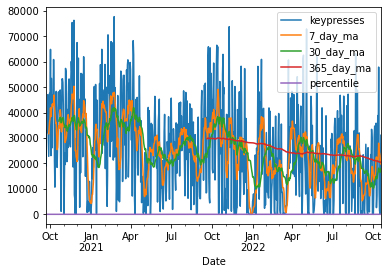

In [7]:
df_combined_daily_keypresses.plot()

Summary daily keypress data statistics:

In [8]:
df_combined_daily_keypresses['keypresses'].describe()

count      758.000000
mean     25623.927441
std      18240.474096
min          0.000000
25%       9612.750000
50%      24919.000000
75%      38760.750000
max      77753.000000
Name: keypresses, dtype: float64

In [9]:
df_combined_daily_keypresses.tail(10) # Last 10 days of data

,keypresses,7_day_ma,30_day_ma,365_day_ma,percentile
Date,,,,,
2022-10-09,7557,22203.714286,13992.400000,20962.389041,0.218997
2022-10-10,27196,21696.000000,14841.366667,20928.065753,0.562005
2022-10-11,38852,22285.000000,16131.266667,20877.304110,0.755937
2022-10-12,25889,21376.000000,16767.266667,20765.994521,0.522427
2022-10-13,57914,27980.285714,18150.166667,20765.580822,0.948549
2022-10-14,10001,24290.428571,17565.333333,20612.336986,0.257256
2022-10-15,1544,24136.142857,16957.166667,20532.312329,0.120053
2022-10-16,0,23056.571429,16545.233333,20531.136986,0.028364
2022-10-17,12127,20903.857143,16889.733333,20563.545205,0.281003


The following cell calculates my top 50 one-day keypress totals.

In [10]:
df_max_keypresses = df_combined_daily_keypresses.sort_values('keypresses', ascending = False).reset_index()
df_max_keypresses.insert(0, 'Rank', df_max_keypresses.index+1)
df_max_keypresses.head(50)

,Rank,Date,keypresses,7_day_ma,30_day_ma,365_day_ma,percentile
0,1,2021-02-22,77753,47983.000000,41921.733333,NaN,1.000000
1,2,2020-11-23,76313,50377.571429,38630.666667,NaN,0.998681
2,3,2020-11-19,75444,47285.571429,38100.900000,NaN,0.997361
3,4,2021-11-09,73788,37843.285714,32561.166667,29584.802740,0.996042
4,5,2022-05-03,72910,30511.428571,29429.400000,24401.624658,0.994723
5,6,2021-02-08,70591,30177.428571,34684.800000,NaN,0.993404
6,7,2021-04-06,68313,40455.857143,41385.233333,NaN,0.992084
7,8,2021-02-15,67930,46174.571429,38828.533333,NaN,0.990765
8,9,2020-11-30,67533,20747.428571,35387.133333,NaN,0.989446
9,10,2021-02-17,67505,45946.571429,40793.766667,NaN,0.988127


<BarContainer object of 50 artists>

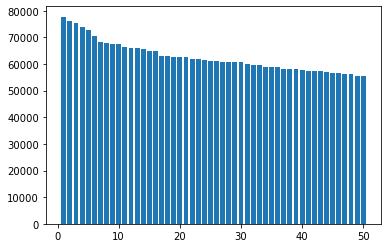

In [11]:
plt.bar(x = df_max_keypresses.head(50)['Rank'], height= df_max_keypresses.head(50)['keypresses'])

In [12]:
df_combined_daily_keypresses.describe()

,keypresses,7_day_ma,30_day_ma,365_day_ma,percentile
count,758.000000,752.000000,729.000000,394.000000,758.000000
mean,25623.927441,25644.466755,25522.633608,25494.337014,0.500660
std,18240.474096,10714.004341,7837.145424,2780.502400,0.288841
min,0.000000,0.000000,10032.533333,20525.517808,0.028364
25%,9612.750000,18015.107143,19954.733333,23310.113014,0.250989
50%,24919.000000,26231.357143,24839.466667,24288.735616,0.500660
75%,38760.750000,33454.750000,31897.033333,28150.078767,0.750330
max,77753.000000,50377.571429,41971.566667,30033.476712,1.000000


In [13]:
df_combined_daily_keypresses['keypresses'].describe(percentiles=np.linspace(0.9,1,11))

count      758.000000
mean     25623.927441
std      18240.474096
min          0.000000
50%      24919.000000
90%      50266.500000
91%      51599.880000
92%      53290.320000
93%      54745.640000
94%      56406.960000
95%      58083.750000
96%      60031.080000
97%      61591.280000
98%      64631.640000
99%      67703.710000
100%     77753.000000
max      77753.000000
Name: keypresses, dtype: float64

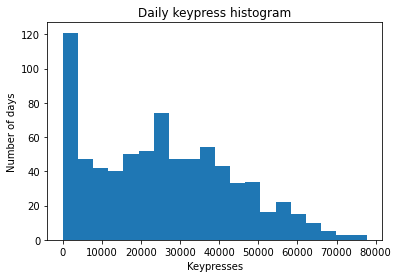

In [14]:
plt.hist(df_combined_daily_keypresses['keypresses'], bins = 20)
plt.xlabel('Keypresses')
plt.ylabel('Number of days')
plt.title('Daily keypress histogram')
plt.savefig('graphs\\keypress_histogram.png')

In [15]:
print("Total keypresess since", str(df_combined_daily_keypresses.index[0])+":",'{:,}'.format(sum(df_combined_daily_keypresses['keypresses'])))

Total keypresess since 2020-09-21 00:00:00: 19,422,937


In [16]:
df_combined_daily_keypresses.tail(50) # Last 50 days

,keypresses,7_day_ma,30_day_ma,365_day_ma,percentile
Date,,,,,
2022-08-30,32002,25691.285714,22683.133333,23029.358904,0.639842
2022-08-31,11142,24014.571429,22246.633333,22955.123288,0.273087
2022-09-01,23291,20976.857143,21599.933333,22964.964384,0.464380
2022-09-02,1457,14205.142857,20770.966667,22922.720548,0.117414
2022-09-03,0,12965.714286,19624.033333,22903.419178,0.028364
2022-09-04,0,12965.714286,18048.666667,22886.435616,0.028364
2022-09-05,1312,9886.285714,18092.333333,22873.175342,0.114776
2022-09-06,0,5314.571429,18048.000000,22815.663014,0.028364
2022-09-07,16172,6033.142857,18045.066667,22743.772603,0.337731


In [17]:
# Total keypresses during MBA:

sum(df_combined_daily_keypresses.query(
    "Date >= '2020-08-20' & Date <= '2022-05-04'")['keypresses'])

16377578

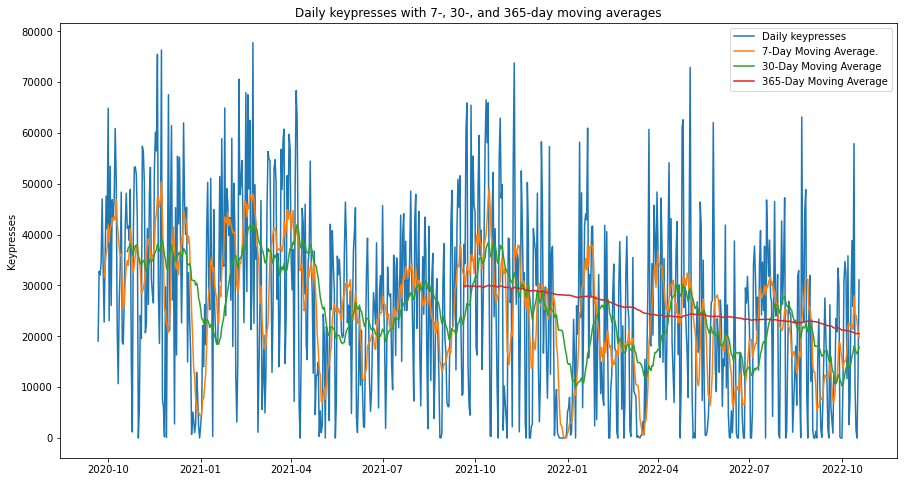

In [18]:
fig, axes = plt.subplots(figsize=[15,8])
fig.set_facecolor('white')

axes.plot(df_combined_daily_keypresses['keypresses'],label='Daily keypresses')
axes.plot(df_combined_daily_keypresses['7_day_ma'],label='7-Day Moving Average.')
axes.plot(df_combined_daily_keypresses['30_day_ma'],label='30-Day Moving Average')
axes.plot(df_combined_daily_keypresses['365_day_ma'],label='365-Day Moving Average')
plt.ylabel('Keypresses')
plt.legend()
plt.title('Daily keypresses with 7-, 30-, and 365-day moving averages')
plt.savefig('graphs\\daily_keypresses_and_MAs.png', dpi=400)

In [19]:
test_df = df_combined_daily_keypresses.copy()

In [20]:
df_monthly_keypresses = test_df.resample('M').sum()['keypresses'].reset_index()
df_monthly_keypresses['Month'] = df_monthly_keypresses['Date'].dt.to_period('M')
df_monthly_keypresses['Year'] = df_monthly_keypresses['Date'].dt.to_period('Y')
df_monthly_keypresses.drop('Date', axis = 1, inplace = True)
df_monthly_keypresses['keypresses'] = df_monthly_keypresses.pop('keypresses')
df_monthly_keypresses

,Month,Year,keypresses
0,2020-09,2020,346918
1,2020-10,2020,1140421
2,2020-11,2020,1061614
3,2020-12,2020,823763
4,2021-01,2021,980116
5,2021-02,2021,1088404
6,2021-03,2021,1142850
7,2021-04,2021,833464
8,2021-05,2021,700155
9,2021-06,2021,621894


The following code shows my monthly keypresses from October to April during my 2-year MBA program.

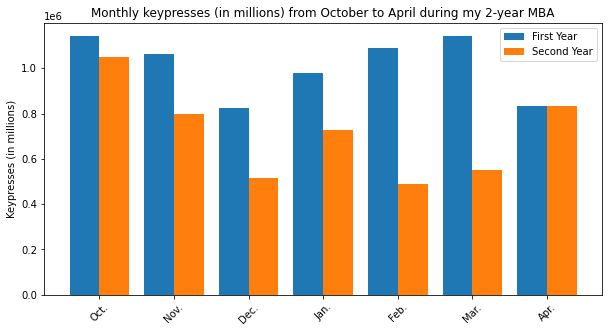

In [21]:
fig, axes = plt.subplots(figsize=[10, 5])
fig.set_facecolor('white')
# Much of the following code was based on:
# https://matplotlib.org/3.5.0/gallery/lines_bars_and_markers/barchart.html
df_first_year = df_monthly_keypresses.query("Month >= '2020-10' & Month <= '2021-04'").copy()
df_second_year = df_monthly_keypresses.query("Month >= '2021-10' & Month <= '2022-04'").copy()
width = 0.4
x = np.arange(len(df_first_year))
axes.bar(x = x - width/2, height = df_first_year['keypresses'], label = 'First Year', width = width)
axes.bar(x = x + width/2, height = df_second_year['keypresses'], label = 'Second Year', width = width)
axes.set_xticks(x, ['Oct.', 'Nov.', 'Dec.', 'Jan.', 'Feb.', 'Mar.', 'Apr.'], rotation = 45)
plt.legend()
plt.ylabel('Keypresses (in millions)')
plt.title('Monthly keypresses (in millions) from October to April during my 2-year MBA')
plt.savefig('graphs\\monthly_keypresses_during_MBA.png', dpi=400)

List of tables in each WhatPulse database file:

In [22]:
# output = sqlalchemy_connection.execute("SELECT name FROM sqlite_schema WHERE type='table' ORDER BY name;") # From https://www.sqlite.org/faq.html#q7 
# print(output.all())
# Tables: [('application_active_hour',), ('application_bandwidth',), ('application_ignore',), ('application_uptime',), ('applications',), ('applications_upgrades',), ('computer_info',), ('country_bandwidth',), ('fact',), ('geekwindow_labels',), ('input_per_application',), ('keycombo_frequency',), ('keycombo_frequency_application',), ('keypress_frequency',), ('keypress_frequency_application',), ('keypresses',), ('last_update_time',), ('milestones',), ('milestones_log',), ('mouseclicks',), ('mouseclicks_frequency',), ('mouseclicks_frequency_application',), ('mousepoints',), ('network_interface_bandwidth',), ('network_interfaces',), ('network_interfaces_ignore',), ('network_protocol_bandwidth',), ('pending_applications_stats',), ('settings',), ('sqlite_sequence',), ('unpulsed_stats',), ('uptimes',)]

In [23]:
df_combined_daily_keypresses.to_csv('whatpulse_daily_keypresses.csv')

In [24]:
end_time = time.time()
run_time = end_time - start_time
run_minutes = run_time // 60
run_seconds = run_time % 60
print("Completed run at",time.ctime(end_time),"(local time)")
print("Total run time:",'{:.2f}'.format(run_time),"second(s) ("+str(run_minutes),"minute(s) and",'{:.2f}'.format(run_seconds),"second(s))") # Only meaningful when the program is run nonstop from start to finish


Completed run at Tue Oct 18 23:12:44 2022 (local time)
Total run time: 14.47 second(s) (0.0 minute(s) and 14.47 second(s))
